### Deep-superficial distance generator and property checker
This notebook is dependent on the ImageAnal.py, load_resolution_xml.py and calc_deep_sup_distance_jupyter.py scripts - these must be at the same folder as the notebook! Also the data mappa should be at the same folder just like for the ImageAnal notebooks...

1) Load dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_point_clicker import clicker #'pip install mpl_point_clicker' command in conda prompt if not installed yet
from typing import Tuple
import ipywidgets as widgets
# custom
from load_resolution_xml import get_resolution
from calc_deep_sup_distance_jupyter import *
from ImageAnal import *

2) Load paths

In [2]:
datapath = os.getcwd() + '/' #current working directory - look for data and strings here!
date_time = '2022-03-18_08-56-03' # date and time of the imaging session
name = 'srb185' # mouse name
task = 'NearFarLong' # task name

## locate the suite2p folder
suite2p_folder = datapath + 'data/' + name + '_imaging/srb185_220318/'

## the name and location of the imaging log file
imaging_logfile_name = suite2p_folder + 'srb185_TSeries-03182022-0800-001.xml'

## the name and location of the trigger voltage file
TRIGGER_VOLTAGE_FILENAME = suite2p_folder + 'srb185_TSeries-03182022-0800-001_Cycle00001_VoltageRecording_001.csv'

3) Run core ImageAnal script

In [3]:
D1 = ImagingSessionData(datapath, date_time, name, task, suite2p_folder, imaging_logfile_name, TRIGGER_VOLTAGE_FILENAME)#, startendlap=[27, 99])

trigger logfile loaded
trigger voltage signal loaded
triggers after: 62
n_extra_indexes 5
candidate log indexes [0, 99, 198, 228]
min recorded trigger length: 0.011200000000144428
relevant behavior located, lap time of the first frame: 145.42866200000014 , log reference index: 99
slight warning - testing some late candidates failed
suite2p data loaded
corrected offset: 145.4266620000002 voltage_delay: 0.00199999999995271
single-plane
suite2p time axis loaded
calculating dF/F and SNR...
SNR done
dF/F calculated for cell ROI-s
ExpStateMachineLog time interval > 1s:  1  times
length of frame_times: 26887
length of frame_laps: 26887
shape of dF_F: (34, 26887)
lap mode = 0
laps with im data:  [ 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  9

C:\Users\luko.balazs\Documents\KOKI\UBI_analyser\ImageAnal.py:1211: RuntimeWarning: divide by zero encountered in double_scalars
  if ( ( (sum(lapsums > 0.6) / float(N_laps_corr)) > 0.2)  & ( (rate_inField / rate_outField) > 7) ):


4) Do the shuffling

In [5]:
cellids = np.arange(D1.N_cells)
D1.calc_shuffle(cellids, 1000, 'shift', batchsize=15, verbous=False)

5) check if there is a distance file already

In [6]:
if os.path.isfile(suite2p_folder+ '/deep_sup_distances.npy'):
    print('file exist')
    output_text=widgets.Text()
    im_opts=['Choose from below:',' - Load distances from file', ' - Reinicialize distances']
    Decision = widgets.Dropdown(options = im_opts,description='Decision:')
    
    def on_value_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            print(change['new'])

            output_text.value=change['new']

    Decision.observe(on_value_change)
    display(Decision)
else:
    File_found=False
    output_text=widgets.Text()
    output_text.value=' - Reinicialize distances'
    print('No previous distance file detected')

file exist


Dropdown(description='Decision:', options=('Choose from below:', ' - Load distances from file', ' - Reiniciali…

 - Load distances from file


6) Load imaging resolution, mean image, center of ROIs and create the canvas to draw line. Dont forget to mark deep orientation also with the x marker!

In [7]:
if output_text.value==' - Reinicialize distances':
    x,y,z = get_resolution(imaging_logfile_name)
    resolution = float(x)

    mean_image_enhanced, x_center, y_center = load_images_centers(suite2p_folder)

    %matplotlib qt
    fig, ax = plt.subplots()
    ax.imshow(mean_image_enhanced, cmap='gray', origin='lower')
    plt.scatter(x_center, y_center, c='r', marker = 'D', s=5)
    #GUI
    klicker = clicker(ax, ['line', 'deep orient.'], markers=['o', 'x'])

7) Run this line if finished with drawing - this will extract the distances in micron or load data or warn you to decide what to do with existing file (two cells before this)

In [12]:
if output_text.value==' - Reinicialize distances':
    %matplotlib inline
    A=deep_superficial(klicker.get_positions(),x_center, y_center, mean_image_enhanced,suite2p_folder, resolution, save = True)
    distances = np.array([np.round_(x,1) for x in A.distances])
if output_text.value==' - Load distances from file':
    print('distances loaded')
    distances = np.load(suite2p_folder+ '/deep_sup_distances.npy')
if output_text.value!=' - Reinicialize distances' and output_text.value!=' - Load distances from file':
    print('Choose what you want to do with previous distance file!')

distances loaded


8.0) plot number of events vs distance

In [13]:
%matplotlib qt
#%matplotlib inline

plt.figure(figsize=(12,8))
plt.scatter(distances, D1.N_events)
plt.xlabel('distance')
plt.ylabel('N events')
plt.show()

8.1) plot SNR vs distances

In [14]:
plt.figure(figsize=(12,8))
plt.scatter(distances, D1.cell_SNR)
plt.xlabel('distance')
plt.ylabel('SNR')
plt.show()

8.2) plot spatial tuning parameters vs distance

separate = 'corridors' means that the colors will be set according to corridors

separate = 'cells' means that the colors will be set according to cells and symbols will code corridors

In [16]:
separate='corridors'
#separate='cells'
plot_vs_distance(distances, D1.cell_skaggs, D1.skaggs_tuned_cells, 'skaggs', ['corr 14','corr 15'], separate)
plot_vs_distance(distances, D1.cell_reliability, D1.reli_tuned_cells, 'reliability', ['corr. 14','corr. 15'], separate)
plot_vs_distance(distances, D1.cell_tuning_specificity, D1.spec_tuned_cells, 'tuning specificity', ['corr. 14','corr. 15'], separate)

8.3) plot number of events vs event rate

In [32]:
total_time = D1.frame_times[-1]-D1.frame_times[0]
total_spikes = np.sum(D1.activity_tensor[:,:,:], axis=2)## bin x cells x laps; all activity in all laps in corridor i
rates = np.sum(total_spikes, axis=0)/total_time #cells

plt.figure(figsize=(8,8))
plt.scatter(rates, D1.N_events)
plt.xlabel('rate')
plt.ylabel('N events')
plt.title('rate vs. N events')
plt.show()

9) check properties

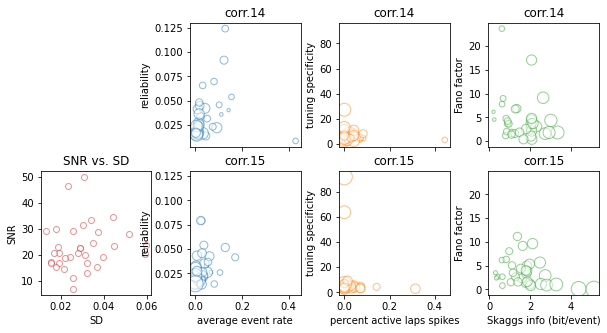

In [42]:
D1.plot_properties()

10) save ImageAnal properties

In [45]:
D1.save_data(True, False, False, False, False)

Session parameters written into file:  cell_properties_corridor_14_N34.csv
cell properties for corridor 14  saved into file:  C:\Users\luko.balazs\Documents\KOKI\UBI_analyser/data/srb185_imaging/srb185_220318/analysed_data/cell_properties_corridor_14_N34.csv
Session parameters written into file:  cell_properties_corridor_15_N34.csv
cell properties for corridor 15  saved into file:  C:\Users\luko.balazs\Documents\KOKI\UBI_analyser/data/srb185_imaging/srb185_220318/analysed_data/cell_properties_corridor_15_N34.csv


11) print distances (to make it easier to add distance property to the data saved the previous cell)

In [17]:
for dist in distances:
    print(dist)

16.143042675467832
15.368857224968558
14.983152698515404
73.75651199928798
-23.301485425593555
-9.222445474142647
92.70731915556364
17.3239978499005
72.26902892657996
47.94092284155512
-15.05470134484108
-10.995488645691937
25.407756116053932
28.73459911747012
93.46370982523267
79.26048623936141
-11.337024512269368
37.1180290573184
39.76272457652897
67.71852168244057
101.91713881011647
37.70932767013093
43.73911519456487
97.85000659656613
81.83463561067842
45.466735689149125
75.72200070301167
63.90730937471389
60.544635421658214
21.236890300102708
7.223096960960758
67.97676274791088
4.895195534493483
-9.368496864239372
